
# Описание данных

**Таблица `visits` (лог сервера с информацией о посещениях сайта)**:

- *Uid* — уникальный идентификатор пользователя
- *Device* — категория устройства пользователя
- *Start Ts* — дата и время начала сессии
- *End Ts* — дата и время окончания сессии
- *Source Id* — идентификатор рекламного источника, из которого пришел пользователь

**Таблица `orders` (информация о заказах)**:

- *Uid* — уникальный id пользователя, который сделал заказ
- *Buy Ts* — дата и время заказа
- *Revenue* — выручка Яндекс.Афиши с этого заказа

**Таблица `costs` (информация о затратах на маркетинг)**:

- *source_id* — идентификатор рекламного источника
- *dt* — дата
- *costs* — затраты на этот рекламный источник в этот день
    
### План работы:
1. Загрузить датасеты
2. Подготовить данные для исследования
3. По данным о продукте, продажах и маркетинге построить отчеты и посчитать метрики. Результаты визуализировать
4. Составить рекомендацию для отдела маркетинга

<a id="info"></a>
# 1. Загрузить данные и изучить общую информацию

### Загрузка библиотек и файлов

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# прочитаем датасеты
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [3]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [7]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


### Вывод

- Первый этап работы с данными состоит из подготовки необходимых библоиотек и загрузки файлов.
- В трех датасетах `orders, visits, costs` содержится информация о пользовательской активности, продажах и тратах.

<a id="data"></a>
# 2. Подготовить данные для исследования

#### Датасет `costs`

In [9]:
# изменим формат данных в столбце dt
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')
print(costs.dtypes)
costs.head()

source_id             int64
dt           datetime64[ns]
costs               float64
dtype: object


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


#### Датасет `visits`

In [10]:
# Переименуем названия столбцов датасета visits
visits.columns = map(str.lower, visits.columns)
visits.columns = visits.columns.str.replace(' ', '_')
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [11]:
# изменим формат данных в столбцах end_ts и start_ts
visits['end_ts'] = pd.to_datetime(visits['end_ts'], format='%Y-%m-%d %H:%M')
visits['start_ts'] = pd.to_datetime(visits['start_ts'], format='%Y-%m-%d %H:%M')
print(visits.dtypes)
visits.head()

device               object
end_ts       datetime64[ns]
source_id             int64
start_ts     datetime64[ns]
uid                  uint64
dtype: object


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


#### Датасет `orders`

In [12]:
# Переименуем названия столбцов датасета orders
orders.columns = map(str.lower, orders.columns)
orders.columns = orders.columns.str.replace(' ', '_')
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [13]:
# изменим формат данных в столбце buy_ts
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], format='%Y-%m-%d %H:%M')
print(orders.dtypes)
orders.head()

buy_ts     datetime64[ns]
revenue           float64
uid                uint64
dtype: object


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


#### Проверка дубликатов

In [14]:
visits.duplicated().sum()

0

In [15]:
orders.duplicated().sum()

0

In [16]:
costs.duplicated().sum()

0

### Вывод

- Для дальнейшей работы с таблицами названия столбцов в orders и visits приведены к общему виду. Изменены типы данных во всех трех датасетах в столбцах со временем, т.е. orders (Buy Ts), visits (End Ts,	Start Ts), costs (dt) приведены к типу datetime.

<a id="summary"></a>
# 3. Подсчет основных метрик

### Продукт

*Проанализируем датасет `visits`, чтобы ответить на вапросы*:

- сколько людей пользуются продуктом в день, неделю, месяц?
- сколько сессий в день?
- сколько длится одна сессия?
- как часто люди возвращаются?

In [17]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [18]:
# изучим, какие есть источники
visits.source_id.unique()

array([ 4,  2,  5,  9,  3,  1, 10,  7,  6])

In [19]:
# добавим колонки с годом, месяцем, неделей и общей датой в новый датасет
df = visits.copy()
df['year'] = df['start_ts'].astype('datetime64[Y]')
df['month'] = df['start_ts'].astype('datetime64[M]')
df['week'] = df['start_ts'].astype('datetime64[W]')
df['date'] = df['start_ts'].dt.date 
df.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27


In [20]:
# ответим на вопрос, сколько людей пользуются в день, неделю, месяц (количество уникальных пользователей)
dau = df.groupby('date').agg({'uid':'nunique'}).mean()
wau = df.groupby(['year', 'week']).agg({'uid':'nunique'}).mean()
mau = df.groupby(['year', 'month']).agg({'uid':'nunique'}).mean()
int(dau), int(wau), int(mau)

(907, 5621, 23228)

In [21]:
# sticky factor показывает, как часто пользователи обращаются к продукту
sticky_wau = dau / wau * 100
sticky_mau = dau / mau * 100
sticky_wau, sticky_mau

(uid    16.151541
 dtype: float64,
 uid    3.90897
 dtype: float64)

####  DAU, WAU, MAU и sticky factor
- В день Яндекс.Афишей пользуются в среднем 907 человек, в неделю - в среднем 5621, в месяц средний показатель равен 23228.
- sticky factor для соотношения день/неделя составляет 16%, в месяц - около 4%.

#### Количество сессий в день

In [22]:
# посчитаем количество сессий на каждого пользователя в день
session_per_day = df.groupby('date').agg({'uid':['nunique', 'count']})
session_per_day.columns = ['n_users', 'n_sessions']
session_per_day['n_per_user'] = session_per_day['n_sessions'] / session_per_day['n_users']
session_per_day.head()

,n_users,n_sessions,n_per_user
date,,,
2017-06-01,605,664,1.097521
2017-06-02,608,658,1.082237
2017-06-03,445,477,1.071910
2017-06-04,476,510,1.071429
2017-06-05,820,893,1.089024


In [23]:
session_per_day['n_per_user'].describe()

count    364.000000
mean       1.082170
std        0.020876
min        1.000000
25%        1.070321
50%        1.082488
75%        1.093876
max        1.217837
Name: n_per_user, dtype: float64

- Средний и медианный показатели по количеству сессий в день равны 1.

#### Продолжительность одной сессии

In [24]:
# посчитаем продолжительность одной сессии  ASL (average session length) в секундах
df['duration_sec'] = (df['end_ts'] - df['start_ts']).dt.seconds
df['duration_sec'].mean()

643.506488592098

Text(0, 0.5, 'количество пользователей')

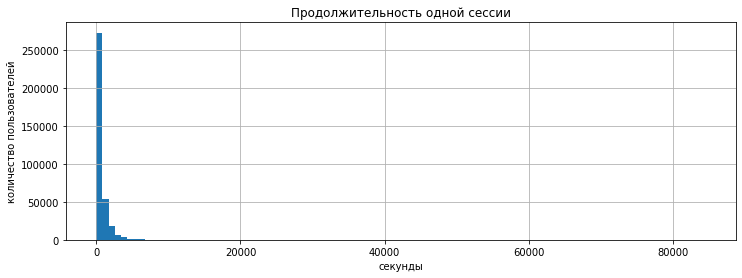

In [25]:
# построим гистограмму для визуализации продолжительности сессий
df['duration_sec'].hist(bins=100, figsize=(12,4))
plt.title('Продолжительность одной сессии')
plt.xlabel('секунды')
plt.ylabel('количество пользователей')

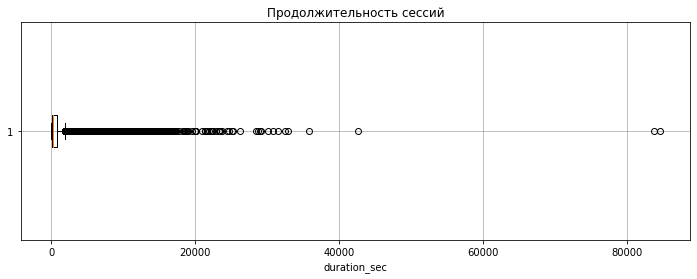

In [26]:
# построим боксплот для того, чтобы оценить выбросы
fig, ax = plt.subplots(figsize=(12,4))
ax.set_title('Продолжительность сессий')
ax.set_xlabel('duration_sec')
ax.boxplot(df['duration_sec'], vert=False)
plt.grid()

In [27]:
# наиболее часто встречаемая продолжительность сессии
df['duration_sec'].mode()

0    60
dtype: int64

In [28]:
# продолжительность сессии на разных устройствах
df.groupby('device')['duration_sec'].agg(['mean', 'median'])

,mean,median
device,,
desktop,703.946977,360
touch,479.619407,180


- Средняя продлжительность одной сессии составляет 644 секунды, или почти 11 минут.
- Чаще всего пользователь проводит на сайте 1 минуту (показатель моды).
- На компьютере средняя продолжительность сессии равна 704 секунды, или почти 12 минут, для других устройств - 480 секунд, или 8 минут.

#### Retention Rate

In [29]:
# выделим дату первой сессии
first_date = df.groupby('uid')['start_ts'].min()
first_date.name = 'first_date'
report = df.join(first_date, on='uid')
report.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration_sec,first_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27,0,2017-12-27 14:06:00


In [30]:
# выделим первый месяц сессии и добавим столбец со временем существования когорты в месяцах
report['first_month'] = report['first_date'].astype('datetime64[M]')
report['cohort_lifetime'] = (report['month'] - report['first_month']) / np.timedelta64(1,'M')
report['cohort_lifetime'] = report['cohort_lifetime'].round().astype('int')
report.head()

,device,end_ts,source_id,start_ts,uid,year,month,week,date,duration_sec,first_date,first_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-01-01,2017-12-01,2017-12-14,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-01-01,2018-02-01,2018-02-15,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-01-01,2017-07-01,2017-06-29,2017-07-01,0,2017-07-01 01:54:00,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-01-01,2018-05-01,2018-05-17,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-01-01,2017-12-01,2017-12-21,2017-12-27,0,2017-12-27 14:06:00,2017-12-01,0


In [31]:
# посчитаем для каждой когорты количество активных пользователей на определённый месяц жизни
cohort_report = report.groupby(['first_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
cohort_report.head()

,first_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


In [32]:
# вычислим число пользователей на нулевой месяц жизни когорты
initial_uid = cohort_report[cohort_report['cohort_lifetime'] == 0][['first_month', 'uid']]
initial_uid = initial_uid.rename(columns={'uid':'cohort_uid'})
cohort_report = cohort_report.merge(initial_uid, on='first_month')
cohort_report.head()

,first_month,cohort_lifetime,uid,cohort_uid
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259
3,2017-06-01,3,814,13259
4,2017-06-01,4,909,13259


In [33]:
# вычислим коэффициент удержания Retention Rate
cohort_report['retention'] = cohort_report['uid'] / cohort_report['cohort_uid']
cohort_report['first_month'] = cohort_report['first_month'].dt.strftime('%Y-%m')
retention_rate = cohort_report.pivot_table(index='first_month', 
                                           columns='cohort_lifetime', 
                                           values='retention', 
                                           aggfunc='sum')

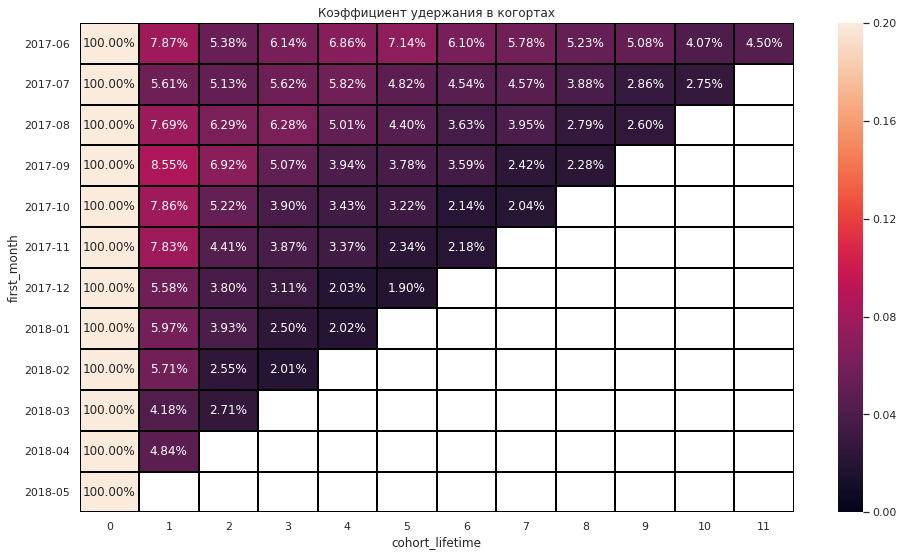

In [34]:
# построим график для retention_rate
sns.set(style='white')
plt.figure(figsize=(16, 9))
plt.title('Коэффициент удержания в когортах')
sns.heatmap(retention_rate, annot=True, fmt='.2%', linewidths=1, linecolor='black', vmin=0, vmax=0.2)

- После выделения времени жизни когорты и количества пользователей на нулевой месяц, мы вычислили коэффициент удержания Retention Rate и отобразили его на графике.
- Коэффициент удержания показывает, какое количество пользователей определенной когорты возвращается ежемесячно. Эти показатели постепенно уменьшаются по мере увеличения продолжительности жизни когорты и приближается к 2% у 6 когорт (с сентября по февраль). Максимальный Retention Rate равен 8,55% (сентябрьская когорта во второй месяц).

### Вывод

- Среднее количество пользователей в день, неделю, месяц связано с показателями daily active users (**DAU**), weekly active users (**WAU**), monthly active users (**MAU**). В исследовании количество уникальных пользователей в день равно **907**, в неделю - **5621**, в месяц - **23228**.
- Среднее количество сессий каждого пользователя в день вычислено через соотношение количества уникальных пользователей в день к числу сессий и держится в рамках 1 сессии в день.
- Средняя продолжительность сессии составляет примерно 644 секунды, или почти 11 минут. Из графиков видно, что есть выбросы, которые влияют на средний показатель и увеличивают его. С компьютеров средняя сессия равна 704 секунды (почти 12 минут), с других устройств - 480 (8 минут).
- Наиболее часто сессия длится 60 секунд, т.е. 1 минуту.
- Коэффициент удержания показывает, какое количество пользователей определенной когорты возвращается ежемесячно. Эти показатели постепенно уменьшаются по мере увеличения продолжительности жизни когорты и приближается к 2% у 6 когорт (с сентября по февраль). Максимальный Retention Rate равен 8,55% (сентябрьская когорта во второй месяц).

### Продажи

*Ответим на вопросы*:
- когда люди начинают покупать?
- сколько раз покупают за период?
- какой средний чек?
- сколько денег приносят? (LTV)

#### Когда начинают покупать?

In [35]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [36]:
# первый визит пользователя
first_visits = (visits.sort_values(by = ['uid', 'start_ts']).groupby('uid')
         .agg({'start_ts' : 'first', 'source_id': 'first', 'device': 'first'}))
first_visits.head()

,start_ts,source_id,device
uid,,,
11863502262781,2018-03-01 17:27:00,3,touch
49537067089222,2018-02-06 15:55:00,2,touch
297729379853735,2017-06-07 18:47:00,3,desktop
313578113262317,2017-09-18 22:49:00,2,desktop
325320750514679,2017-09-30 14:29:00,5,desktop


In [37]:
users_orders = first_visits.merge(orders, on='uid', how='inner')
users_orders.head()

,uid,start_ts,source_id,device,buy_ts,revenue
0,313578113262317,2017-09-18 22:49:00,2,desktop,2018-01-03 21:51:00,0.55
1,1575281904278712,2017-06-03 10:13:00,10,touch,2017-06-03 10:13:00,1.22
2,1575281904278712,2017-06-03 10:13:00,10,touch,2017-06-03 17:39:00,1.83
3,2429014661409475,2017-10-11 17:14:00,3,desktop,2017-10-11 18:33:00,73.33
4,2464366381792757,2018-01-27 20:10:00,5,desktop,2018-01-28 15:54:00,2.44


In [38]:
# вычислим, когда начинают покупать (в секундах)
users_orders['first_buy'] = (users_orders['buy_ts'] - users_orders['start_ts']).dt.total_seconds()
users_orders['first_buy'].describe()

count    5.041500e+04
mean     3.199986e+06
std      6.100780e+06
min      0.000000e+00
25%      3.600000e+02
50%      1.236000e+04
75%      3.316950e+06
max      3.148014e+07
Name: first_buy, dtype: float64

In [39]:
# медианное значение столбца first_buy
users_orders['first_buy'].median()

12360.0

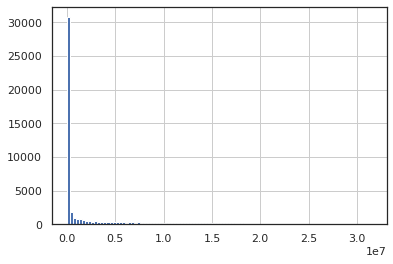

In [40]:
# построим график распределения
users_orders['first_buy'].hist(bins=100, grid=True)

In [41]:
users_orders['first_buy'].mode()

0    60.0
dtype: float64

- Чтобы вычислить, когда пользователи начинают покупать, в датасете visits выделены самые первые визиты. Затем в объединенном датасете users_buy добавлен столбец со временем покупок. Гистограмма показывает, что в данных много выбросов, поэтому за основу анализа взяты медиана и мода.
- Если говорить о медианном показателе, то пользователи начинают покупать в течение первых 3 часов посещения сайта (12360 сек).
- При этом наиболее часто покупка совершается в течение минуты с начала сессии (показатель моды).

#### Количество покупок за период

In [42]:
# добавим столбец с месяцем заказа к таблице orders
orders['order_month'] = orders.buy_ts.astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [43]:
# добавим столбуц с датой заказа к таблице orders
orders_copy = orders.copy()
orders_copy['orders_date'] = orders_copy['buy_ts'].dt.date
orders_copy.head()

,buy_ts,revenue,uid,order_month,orders_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [44]:
# среднее количество покупок на пользователя в день
orders_per_user_daily = orders_copy.groupby('orders_date').agg({'uid':['nunique', 'count']})
orders_per_user_daily.columns = ['n_users', 'n_sessions']
orders_per_user_daily['n_per_user'] = orders_per_user_daily['n_sessions'] / orders_per_user_daily['n_users']
orders_per_user_daily['n_per_user'].mean()

1.0793603882550205

#### <Сколько покупают за период

In [45]:
# добавим дату первой покупки
first_order_date = orders.groupby('uid')['buy_ts'].min()
first_order_date.name = 'first_order_datetime'
orders = orders.join(first_order_date, on='uid')
orders.head()

,buy_ts,revenue,uid,order_month,first_order_datetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00


In [46]:
# месяц первого заказа
orders['first_order_month'] = orders['first_order_datetime'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,order_month,first_order_datetime,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01


In [47]:
# количество покупок в месяц
buying = orders.groupby(['first_order_month','order_month']).agg({'uid':['nunique', 'count']}).reset_index()
buying.columns = ['first_order_month', 'order_month', 'n_users', 'n_orders']
buying['n_orders_per_user'] = buying['n_orders'] / buying['n_users']
buying['first_order_month'] = buying['first_order_month'].dt.strftime('%Y-%m')
buying['order_month'] = buying['order_month'].dt.strftime('%Y-%m')
buying_pivot = buying.pivot_table(index='first_order_month', columns='order_month', values='n_orders_per_user', aggfunc='mean').round()

In [48]:
# среднее количество покупок в месяц
buying['n_orders_per_user'].mean()

1.8589644143998318

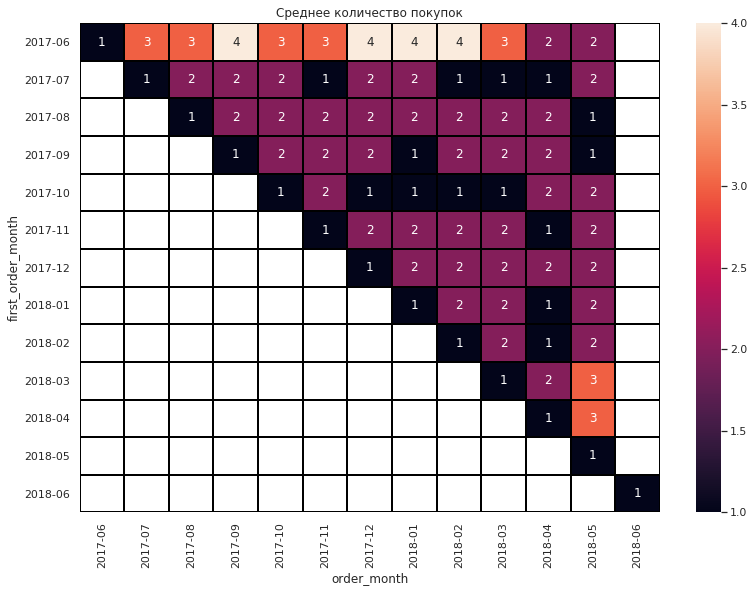

In [49]:
plt.figure(figsize=(13, 9))
plt.title('Среднее количество покупок')
sns.heatmap(buying_pivot, annot=True, linewidths=1, linecolor='black')

- Ежемесячно в разных когортах покупают от 1 до 4 раз. Среднее значение приближается к 2. Покупатели первой когорты приобретают товар 3-4 раза в месяц с июля 2017 года по март 2018 года.

#### Изменение среднего чека

In [50]:
# определим размер когорт по таблице orders и посчитаем выручку с пользователя
cohort_orders_grouped = (orders.groupby(['first_order_month','order_month'])
                               .agg({'revenue':'sum','uid':'nunique'}))
cohort_orders_grouped['revenue_per_user'] = cohort_orders_grouped['revenue'] / cohort_orders_grouped['uid']
cohort_orders_grouped.head()

revenue   uid  revenue_per_user
first_order_month order_month                                 
2017-06-01        2017-06-01   9557.49  2023          4.724414
                  2017-07-01    981.82    61         16.095410
                  2017-08-01    885.34    50         17.706800
                  2017-09-01   1931.30    54         35.764815
                  2017-10-01   2068.58    88         23.506591

In [51]:
# выделим время жизни когорты в месяцах
cohort_orders_grouped = cohort_orders_grouped.reset_index()
cohort_orders_grouped['cohort_lifetime'] = (cohort_orders_grouped['order_month'] - cohort_orders_grouped['first_order_month']) / np.timedelta64(1,'M')
cohort_orders_grouped['cohort_lifetime'] = cohort_orders_grouped['cohort_lifetime'].round().astype('int')


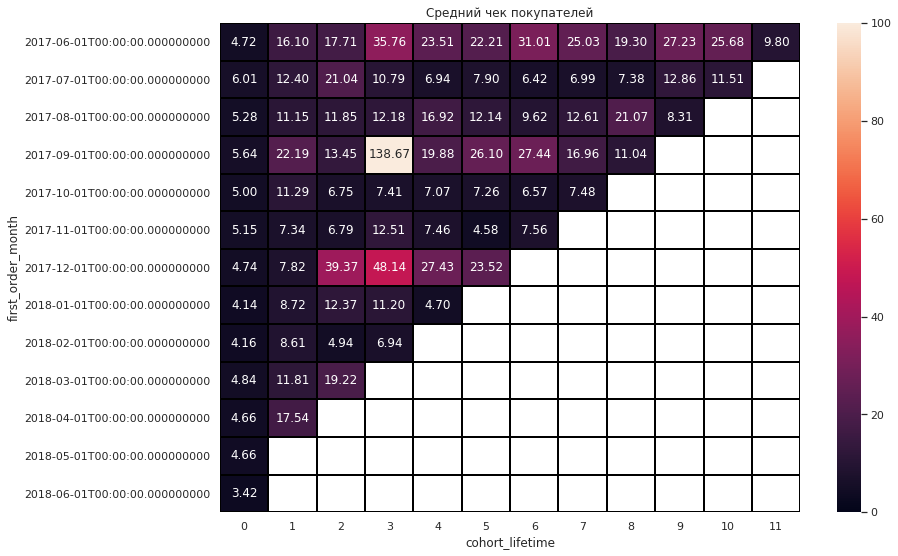

In [52]:
# построим итоговую таблицу по среднему чеку и выведем на тепловой карте
revenue_per_user_result = cohort_orders_grouped.pivot_table(index='first_order_month',
                                                         columns='cohort_lifetime',
                                                         values='revenue_per_user',
                                                         aggfunc='mean')
plt.figure(figsize=(13, 9))
plt.title('Средний чек покупателей')
sns.heatmap(revenue_per_user_result, annot=True, fmt='.2f', linewidths=1, linecolor='black', vmin=0, vmax=100)

#### Средний чек пользователя

In [53]:
# средняя выручка по всем пользователям
cohort_orders_grouped['revenue_per_user'].mean()

14.73356759726224

- Средний чек покупателя составляет 14.7. В некоторых когортах средний чек постепенно растет, но затем снижается (как в июньской когорте достигает максимума в 35.76 в сентябре, но к маю 2018 года опускается до 9.8), в других есть резкий скачок в декабре (138.67 у сентябрьской когорты). 
- У всех когорт средний чек последнего месяца выше среднего чека нулевого месяца. Он может отличаться незначительно, как в январской когорте (4.14 и 4.70), или же увеличиться в несколько раз, как в декабрьской когорте (4.74 и 23.52)

#### Ценность клиента (LTV)

In [54]:
# размер когорт
cohort_size = orders.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
cohort_size.columns = ['first_order_month', 'n_buyers']
cohort_size

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


In [55]:
# изменение формата и объединение в результирующую таблицу
result = cohort_size.merge(cohort_orders_grouped, on='first_order_month')
result.head()

,first_order_month,n_buyers,order_month,revenue,uid,revenue_per_user,cohort_lifetime
0,2017-06-01,2023,2017-06-01,9557.49,2023,4.724414,0
1,2017-06-01,2023,2017-07-01,981.82,61,16.095410,1
2,2017-06-01,2023,2017-08-01,885.34,50,17.706800,2
3,2017-06-01,2023,2017-09-01,1931.30,54,35.764815,3
4,2017-06-01,2023,2017-10-01,2068.58,88,23.506591,4


In [56]:
# разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте и найдём LTV
# показатели первых 6 месяцев жизни
result['ltv'] = result['revenue'] / result['n_buyers']
result = result[result['cohort_lifetime'] < 6]
result_pivot = result.pivot_table(index='first_order_month', 
                                  columns='cohort_lifetime',
                                  values='ltv',
                                  aggfunc='mean')

#### Дополнительные показатели LTV

In [57]:
# показатели усредненной когорты за полгода
result_pivot.cumsum(axis=1).mean(axis=0)

cohort_lifetime
0    4.801682
1    5.395666
2    5.821811
3    6.689763
4    7.298634
5    7.969053
dtype: float64

In [58]:
# средний ltv на 0 месяц
result_pivot.cumsum(axis=1).mean(axis=0)[0]

4.801682381794591

In [59]:
# средний ltv за полгода
ltv_half_year = result_pivot.cumsum(axis=1).mean(axis=0)[5]
ltv_half_year

7.969052630207335

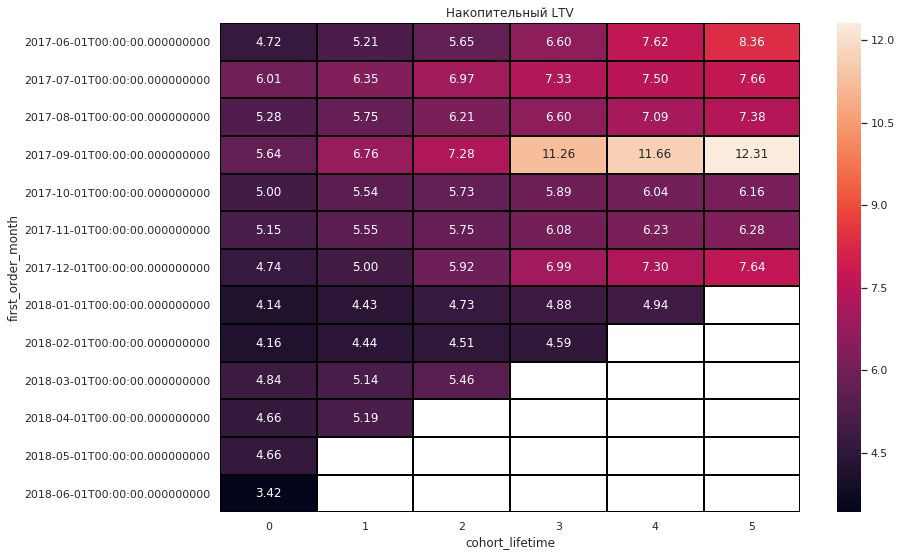

In [60]:
# накопительный LTV за полгода
cum_ltv = result_pivot.cumsum(axis=1)
plt.figure(figsize=(13, 9))
plt.title('Накопительный LTV')
sns.heatmap(cum_ltv, annot=True, fmt='.2f', linewidths=1, linecolor='black')

За полгода ценность пользователя растет от 4.8 почти до 8 (средний показатель увеличился до 7.97). Самый высокий показатель у сентябрьской когорты: 12.3 к концу 6 месяца. Остальные LTV 6 когорт варьируются от 6.16 до 8.36

### Вывод

- Пользователи начинают покупать в среднем в течение 3 часов после или во время своей первой сессии
- Среднее количество покупок одного пользователя в месяц приближаетя к 2. Но, например, в июньской когорте число покупок может равняться 3 и 4.
- Средний чек покупателя составляет 14.7. Средний чек пользователей постоянно меняется: в некоторых когортах он постепенно растет, но затем снижается (как в июньской когорте достигает максимума в 35.76 в сентябре, но к маю 2018 года опускается до 9.8), в других есть резкий скачок в декабре (138.67 у сентябрьской когорты). У всех когорт средний чек последнего месяца выше среднего чека нулевого месяца. Он может отличаться незначительно, как в январской когорте (4.14 и 4.70), или же увеличиться в несколько раз, как в декабрьской когорте (4.74 и 23.52).
- Lifetime value постепенно увеличивается, т.е. клиент приносит больше прибыли со всех своих покупок. За полгода ценность пользователя растет от 4.8 почти до 8 (средний показатель увеличился до 7.97). Самый высокий показатель у сентябрьской когорты: 12.3 к концу 6 месяца. Остальные LTV 6 когорт варьируются от 6.16 до 8.36.

### Маркетинг

*Ответим на следующие вопросы*:
- сколько денег потратили? Всего / на каждый источник / по времени
- сколько стоило привлечение одного покупателя из каждого источника?
- на сколько окупились расходы? (ROI)

In [61]:
# добавим столбец с месяцем в таблицу costs
costs['month'] = costs['dt'].astype('datetime64[M]')
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [62]:
# посчитаем общие затраты
costs.costs.sum()

329131.62

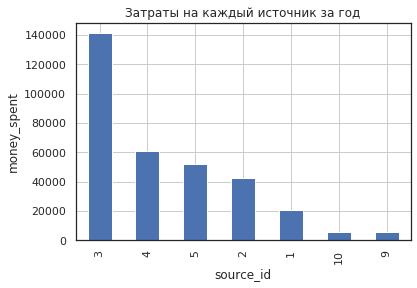

In [63]:
# Затраты на каждый источник за год
source_costs = costs.groupby('source_id')['costs'].sum()
source_costs.sort_values(ascending=False).plot(kind='bar', grid=True, title='Затраты на каждый источник за год')
plt.ylabel('money_spent')
plt.show()

In [64]:
source_costs

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

Text(0.5, 0, 'money_spent')

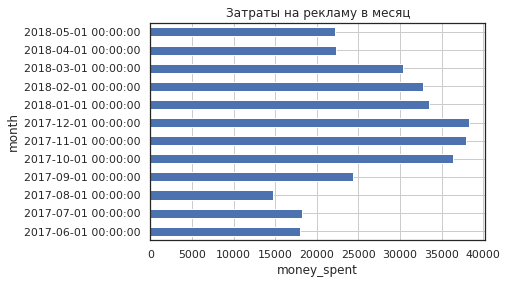

In [65]:
# Затраты по месяцам
monthly_cost = costs.groupby('month')['costs'].sum()
monthly_cost.plot(kind='barh', grid=True, title='Затраты на рекламу в месяц')
plt.xlabel('money_spent')

- Исходя из полученных данных таблицы `costs`, всего было потрачено на рекламу **329132**. На отдельные источники суммы распределились следующим образом: 141321.63 на 3 источник, 61073.60 на 4, 51757.10 на 5, 42806.04 на 2, 20833.27 на 1, 5822.49 на 10 и 5517.49 на 9. По месяцам максимальная сумма была потрачена в декабре 2017 года (38315.35), а также в ноябре (37907.88) и октябре (36322.88). Минимальная летом: в августе того же года (14790.54), затем следуют июнь (18015.00) и июль (18240.59). Максимальные затраты были за три месяца до Нового года и в течение трех месяце после.

In [68]:
costs.dtypes

source_id             int64
dt           datetime64[ns]
costs               float64
month        datetime64[ns]
dtype: object

In [69]:
costs_copy = costs.copy()

#### Сколько стоило привлечение одного покупателя из каждого источника

In [70]:
costs_copy['acquisition_date'] = costs['dt']
costs_copy.head()

,source_id,dt,costs,month,acquisition_date
0,1,2017-06-01,75.20,2017-06-01,2017-06-01
1,1,2017-06-02,62.25,2017-06-01,2017-06-02
2,1,2017-06-03,36.53,2017-06-01,2017-06-03
3,1,2017-06-04,55.00,2017-06-01,2017-06-04
4,1,2017-06-05,57.08,2017-06-01,2017-06-05


In [71]:
# таблица для подсчета индивидуальных рекламных расходов на пользователя
# профили платящих пользователей (первая сессия, первое устройство)
paying_users = (visits[visits['uid'].isin(orders['uid'].unique())]
                .sort_values(by=['uid', 'start_ts']).groupby('uid')
                .agg({'start_ts':'first', 'source_id':'first', 'device':'first'})
                .rename(columns={'start_ts':'acquisition_ts'}))
paying_users['acquisition_date'] = paying_users['acquisition_ts'].dt.date
paying_users['acquisition_month'] = paying_users['acquisition_ts'].astype('datetime64[M]')
paying_users = (paying_users.reset_index().set_index(['source_id', 'acquisition_date'])
                .join(costs_copy.set_index(['source_id', 'acquisition_date']), how='left'))

paying_users.head()

uid      acquisition_ts   device  \
source_id acquisition_date                                                     
1         2017-06-01         469568501030474895 2017-06-01 05:30:00  desktop   
          2017-06-01        1074355127080856382 2017-06-01 09:21:00  desktop   
          2017-06-01        1292867924428534308 2017-06-01 12:53:00  desktop   
          2017-06-01        2050423809815667474 2017-06-01 10:36:00  desktop   
          2017-06-01        3520273333047097992 2017-06-01 20:08:00  desktop   

                           acquisition_month         dt  costs      month  
source_id acquisition_date                                                 
1         2017-06-01              2017-06-01 2017-06-01   75.2 2017-06-01  
          2017-06-01              2017-06-01 2017-06-01   75.2 2017-06-01  
          2017-06-01              2017-06-01 2017-06-01   75.2 2017-06-01  
          2017-06-01              2017-06-01 2017-06-01   75.2 2017-06-01  
          2017-06-01              2017-06-01 2017-06-01   75.2 2017-06-01

In [72]:
# стоимость привлечения одного платящего пользователя
user_cost = (paying_users.groupby(['source_id', 'acquisition_date']).agg({'device':'count', 'costs':'max'})
             .rename(columns = {'device':'users'}))
user_cost['payer_acquisition_cost'] = user_cost['costs'] / user_cost['users']
user_cost

users  costs  payer_acquisition_cost
source_id acquisition_date                                      
1         2017-06-01           24  75.20                3.133333
          2017-06-02           12  62.25                5.187500
          2017-06-03            8  36.53                4.566250
          2017-06-04            6  55.00                9.166667
          2017-06-05           20  57.08                2.854000
...                           ...    ...                     ...
10        2018-05-27            2   9.92                4.960000
          2018-05-28            7  21.26                3.037143
          2018-05-29            4  11.32                2.830000
          2018-05-30           10  33.15                3.315000
          2018-05-31           25  17.60                0.704000

[2400 rows x 3 columns]

In [73]:
# добавим столбец с доходами по пользователю
paying_users = paying_users.join(user_cost[['payer_acquisition_cost']], how='left')
paying_users = paying_users.reset_index().set_index('uid')[['acquisition_ts', 'acquisition_date', 'acquisition_month', 
                                                            'source_id', 'device', 'payer_acquisition_cost']]
paying_users = (paying_users.join(((orders.groupby('uid'))
                .agg({'revenue':'sum'})
                .rename(columns={'revenue':'total_revenue'})), how='left'))
paying_users.head()

,acquisition_ts,acquisition_date,acquisition_month,source_id,device,payer_acquisition_cost,total_revenue
uid,,,,,,,
469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,3.133333,70.69
1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,3.133333,0.37
1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,3.133333,4.28
2050423809815667474,2017-06-01 10:36:00,2017-06-01,2017-06-01,1,desktop,3.133333,8.31
3520273333047097992,2017-06-01 20:08:00,2017-06-01,2017-06-01,1,desktop,3.133333,0.24


In [74]:
paying_users = paying_users.reset_index()
paying_users.head()

,uid,acquisition_ts,acquisition_date,acquisition_month,source_id,device,payer_acquisition_cost,total_revenue
0,469568501030474895,2017-06-01 05:30:00,2017-06-01,2017-06-01,1,desktop,3.133333,70.69
1,1074355127080856382,2017-06-01 09:21:00,2017-06-01,2017-06-01,1,desktop,3.133333,0.37
2,1292867924428534308,2017-06-01 12:53:00,2017-06-01,2017-06-01,1,desktop,3.133333,4.28
3,2050423809815667474,2017-06-01 10:36:00,2017-06-01,2017-06-01,1,desktop,3.133333,8.31
4,3520273333047097992,2017-06-01 20:08:00,2017-06-01,2017-06-01,1,desktop,3.133333,0.24


In [75]:
n_paying_users = paying_users.groupby(['source_id', 'acquisition_month']).agg({'uid':'count'})
n_paying_users.columns = ['n_paying_users']
n_paying_users

n_paying_users
source_id acquisition_month                
1         2017-06-01                    240
          2017-07-01                    184
          2017-08-01                    126
          2017-09-01                    248
          2017-10-01                    350
...                                     ...
10        2018-01-01                    103
          2018-02-01                    113
          2018-03-01                    166
          2018-04-01                     98
          2018-05-01                    101

[85 rows x 1 columns]

In [76]:
# общая стоимость привлечения покупателей и выручка по источникам и в определнный месяц
source_report = paying_users.groupby(['source_id', 'acquisition_month']).agg({'payer_acquisition_cost':'sum', 'total_revenue':'sum'})
source_report = source_report.join(n_paying_users, on=['source_id', 'acquisition_month'], how='left')
source_report

payer_acquisition_cost  total_revenue  \
source_id acquisition_month                                          
1         2017-06-01                        1082.37        9910.69   
          2017-07-01                        1072.88        2341.21   
          2017-08-01                         951.81        2624.27   
          2017-09-01                        1502.01        2414.97   
          2017-10-01                        2315.75        3252.30   
...                                             ...            ...   
10        2018-01-01                         556.16         369.68   
          2018-02-01                         473.94         261.92   
          2018-03-01                         526.41         545.28   
          2018-04-01                         360.97         258.70   
          2018-05-01                         355.32         364.34   

                             n_paying_users  
source_id acquisition_month                  
1         2017-06-01                    240  
          2017-07-01                    184  
          2017-08-01                    126  
          2017-09-01                    248  
          2017-10-01                    350  
...                                     ...  
10        2018-01-01                    103  
          2018-02-01                    113  
          2018-03-01                    166  
          2018-04-01                     98  
          2018-05-01                    101  

[85 rows x 3 columns]

In [77]:
source_report['cac'] = source_report['payer_acquisition_cost'] / source_report['n_paying_users']
source_report.head()

payer_acquisition_cost  total_revenue  \
source_id acquisition_month                                          
1         2017-06-01                        1082.37        9910.69   
          2017-07-01                        1072.88        2341.21   
          2017-08-01                         951.81        2624.27   
          2017-09-01                        1502.01        2414.97   
          2017-10-01                        2315.75        3252.30   

                             n_paying_users       cac  
source_id acquisition_month                            
1         2017-06-01                    240  4.509875  
          2017-07-01                    184  5.830870  
          2017-08-01                    126  7.554048  
          2017-09-01                    248  6.056492  
          2017-10-01                    350  6.616429

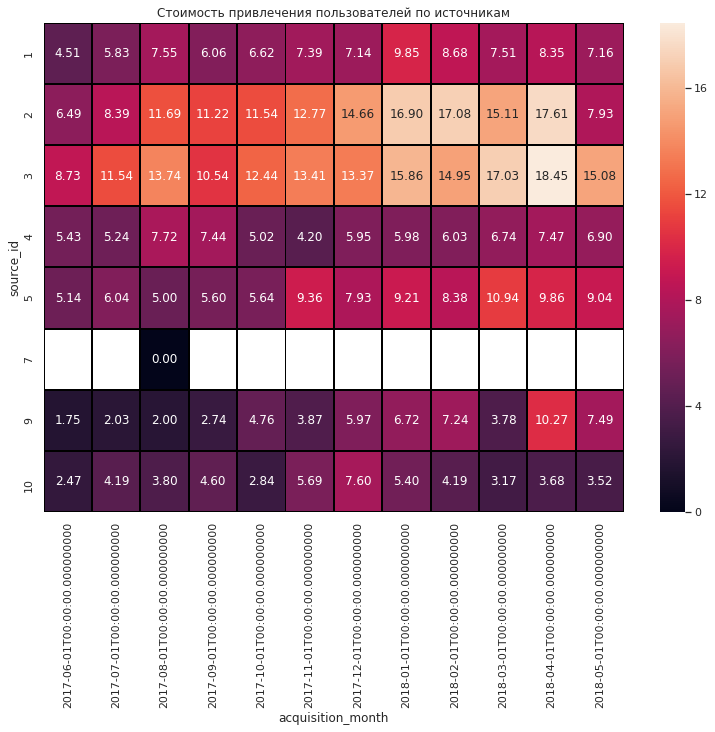

In [78]:
# стоимость привлечения одного покупателя из разных истоников
source_pivot = source_report.pivot_table(index='source_id', 
                                         columns='acquisition_month', 
                                         values='cac', 
                                         aggfunc='mean')

plt.figure(figsize=(13, 9))
plt.title('Стоимость привлечения пользователей по источникам')
sns.heatmap(source_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='black')

In [79]:
# таблица со средними значениями CAC по источникам
source_cac = source_report.groupby('source_id')['cac'].mean().to_frame()
print(source_cac['cac'].mean())
source_cac

7.0751569819828735


,cac
source_id,
1,7.219979
2,12.616454
3,13.761162
4,6.175427
5,7.679106
7,0.000000
9,4.885612
10,4.263516


Text(0.5, 1.0, 'Средняя стоимость привлечения одного покупателя по источникам')

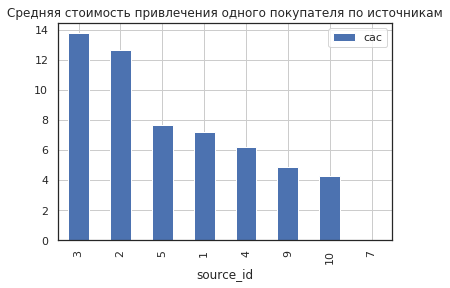

In [80]:
source_cac.sort_values(by='cac', ascending=False).plot(kind='bar', grid=True)
plt.title('Средняя стоимость привлечения одного покупателя по источникам')

- Средние показатели привлечения покупателя по всем источникам равны 7. Однако распределение по отдельным источникам отличается: самые дорогие источники - №3 (13.8) и 2 (12.6), 5 и 1 стоят 7.7, 7.2 соответственно. Покупатели 4 источника обходятся в 6.2, 9 - 4.9, 10 - 4.3.

In [81]:
# данные из общей таблицы
source_report['ltv'] = source_report['total_revenue'] / source_report['n_paying_users']
source_report['roi'] = source_report['ltv'] / source_report['cac']
#source_roi = source_report.pivot_table(index='source_id', 
                                       #columns='acquisition_month', 
                                       #values='roi', 
                                       #aggfunc='mean').cumsum(axis=1)

In [82]:
# таблица со средними значениями CAC по источникам
source_ltv = source_report.groupby('source_id')['ltv'].mean().to_frame()
source_ltv

,ltv
source_id,
1,11.238028
2,12.514724
3,5.261197
4,5.767742
5,7.376510
7,1.220000
9,5.097752
10,3.506466


In [83]:
# roi по данным двух таблиц
source_roi = (source_ltv['ltv'] / source_cac['cac']).to_frame()
source_roi.columns = ['roi']
source_roi

,roi
source_id,
1,1.556518
2,0.991937
3,0.382322
4,0.933983
5,0.960595
7,inf
9,1.043421
10,0.822435


Text(0, 0.5, 'roi')

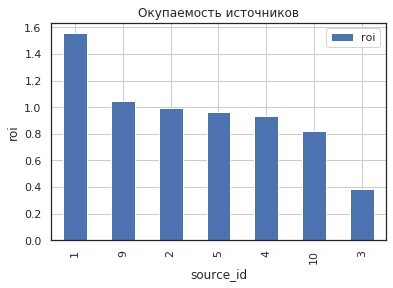

In [84]:
# данные по окупаемости источников за год
source_roi.query('source_id != 7').sort_values(by='roi', ascending=False).plot(kind='bar', grid=True)
plt.title('Окупаемость источников')
plt.ylabel('roi')

- В итоговой таблице проанализированы источники 1, 2, 3, 4, 5, 9 и 10. За исследуемый период окупились рекламные источники № 1 (156%) и 9 (100%), тогда как 2 (99%), 5 (96%), 4 (93%) только приближаются к 100% окупаемости. Самый низкий показатель roi у источника № 3 (38%).

#### Device

In [85]:
# количество покупателей по устройствам в месяц
n_paying_users_device = paying_users.reset_index().groupby(['device', 'acquisition_month']).agg({'uid':'count'})
n_paying_users_device.columns = ['n_paying_users_device']
n_paying_users_device

n_paying_users_device
device  acquisition_month                       
desktop 2017-06-01                          2387
        2017-07-01                          1918
        2017-08-01                          1390
        2017-09-01                          2416
        2017-10-01                          3800
        2017-11-01                          3454
        2017-12-01                          3276
        2018-01-01                          2464
        2018-02-01                          2484
        2018-03-01                          2239
        2018-04-01                          1544
        2018-05-01                          1839
touch   2017-06-01                           536
        2017-07-01                           540
        2017-08-01                           331
        2017-09-01                           642
        2017-10-01                           878
        2017-11-01                           808
        2017-12-01                           798
        2018-01-01                           655
        2018-02-01                           702
        2018-03-01                           599
        2018-04-01                           346
        2018-05-01                           477

In [86]:
# общая стоимость привлечения покупателей и выручка по устройствам и в определенный месяц
device_report = paying_users.groupby(['device', 'acquisition_month']).agg({'payer_acquisition_cost':'sum', 'total_revenue':'sum'})
device_report = device_report.join(n_paying_users_device, on=['device', 'acquisition_month'], how='left')
device_report

payer_acquisition_cost  total_revenue  \
device  acquisition_month                                          
desktop 2017-06-01                   14738.667425       35403.63   
        2017-07-01                   14300.702753       14083.05   
        2017-08-01                   11756.758764       10361.93   
        2017-09-01                   19201.182867       29243.29   
        2017-10-01                   29725.056658       22885.48   
        2017-11-01                   30869.279241       20153.92   
        2017-12-01                   30668.109144       27354.28   
        2018-01-01                   26567.458931       11893.38   
        2018-02-01                   25185.589773       12275.84   
        2018-03-01                   24433.160630       10872.78   
        2018-04-01                   18159.663884        8361.58   
        2018-05-01                   17577.420489        8440.61   
touch   2017-06-01                    3182.232575        4622.42   
        2017-07-01                    3766.147247        3729.06   
        2017-08-01                    2813.611236        3099.94   
        2017-09-01                    5056.777133        4439.27   
        2017-10-01                    6563.053342        4972.21   
        2017-11-01                    6944.670759        4272.80   
        2017-12-01                    7462.890856        3803.57   
        2018-01-01                    6715.211069        2653.44   
        2018-02-01                    7355.640227        2785.45   
        2018-03-01                    5844.709370        2897.38   
        2018-04-01                    3872.656116        1520.97   
        2018-05-01                    4454.809511        1930.92   

                           n_paying_users_device  
device  acquisition_month                         
desktop 2017-06-01                          2387  
        2017-07-01                          1918  
        2017-08-01                          1390  
        2017-09-01                          2416  
        2017-10-01                          3800  
        2017-11-01                          3454  
        2017-12-01                          3276  
        2018-01-01                          2464  
        2018-02-01                          2484  
        2018-03-01                          2239  
        2018-04-01                          1544  
        2018-05-01                          1839  
touch   2017-06-01                           536  
        2017-07-01                           540  
        2017-08-01                           331  
        2017-09-01                           642  
        2017-10-01                           878  
        2017-11-01                           808  
        2017-12-01                           798  
        2018-01-01                           655  
        2018-02-01                           702  
        2018-03-01                           599  
        2018-04-01                           346  
        2018-05-01                           477

In [87]:
# стоимость привлечения одного покупателя
device_report['cac'] = device_report['payer_acquisition_cost'] / device_report['n_paying_users_device']
device_report.pivot_table(index='device', columns='acquisition_month', values='cac', aggfunc='mean')

acquisition_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
device,,,,,,,,,,,,
desktop,6.174557,7.456049,8.458100,7.947509,7.822383,8.937255,9.361450,10.782248,10.139126,10.912533,11.761440,9.558141
touch,5.937001,6.974347,8.500336,7.876600,7.475004,8.594890,9.351994,10.252231,10.478120,9.757445,11.192648,9.339223


In [88]:
# таблица cac по устройствам
device_cac = device_report.groupby('device')['cac'].mean().to_frame()
device_cac

,cac
device,
desktop,9.109233
touch,8.810820


- Средние показатели привлечения покупателя по устройствам выглядят следующим образом: desktop - 9.1, touch - 8.8.

In [89]:
#  таблица ltv по устройствам
device_report['ltv'] = device_report['total_revenue'] / device_report['n_paying_users_device']
device_ltv = device_report.groupby('device')['ltv'].mean().to_frame()
device_ltv

,ltv
device,
desktop,7.214219
touch,5.735600


Text(0.5, 0, 'roi')

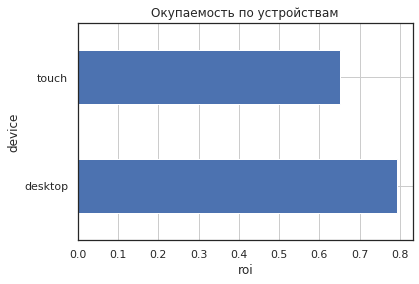

In [90]:
# посчитаем окупаемость, исходя из данных по устройствам
roi = device_ltv['ltv'] / device_cac['cac']
roi.plot(kind='barh', grid=True)
plt.title('Окупаемость по устройствам')
plt.xlabel('roi')

- ROI по устройствам за год показатели следующие: touch - 57%, desktop - 72%

### Вывод

- Исходя из полученных данных таблицы `costs`, всего было потрачено на рекламу **329132**. На отдельные источники суммы распределились следующим образом: 141321.63 на 3 источник, 61073.60 на 4, 51757.10 на 5, 42806.04 на 2, 20833.27 на 1, 5822.49 на 10 и 5517.49 на 9. По месяцам максимальная сумма была потрачена в декабре 2017 года (38315.35), а также в ноябре (37907.88) и октябре (36322.88). Минимальная летом: в августе того же года (14790.54), затем следуют июнь (18015.00) и июль (18240.59). Максимальные затраты были за три месяца до Нового года и в течение трех месяце после.
- Средние показатели привлечения одного покупателя (cac) по всем источникам равны 7. Однако распределение по отдельным источникам отличается: самые дорогие источники - №3 (13.8) и 2 (12.6), 5 и 1 стоят 7.7, 7.2 соответственно. Покупатели 4 источника обходятся в 6.2, 9 - 4.9, 10 - 4.3.
- Средние показатели привлечения покупателя (cac) по устройствам выглядят следующим образом: desktop - 9.1, touch - 8.8.
- В итоговой таблице проанализированы источники 1, 2, 3, 4, 5, 9 и 10. За исследуемый период окупились рекламные источники № 1 (156%) и 9 (100%), тогда как 2 (99%), 5 (96%), 4 (93%) только приближаются к 100% окупаемости. Самый низкий показатель roi у источника № 3 (38%).
- По устройствам за год показатели ROI следующие: touch - 57%, desktop - 72%

<a id="conclusion"></a>
# 4. Общий вывод

- *Для анализа выбраны данные с июня 2017 по конец мая 2018 года, в которых собраны лог сервера с данными о посещениях сайта Яндекс.Афиши, выгрузка всех заказов за этот период, статистика рекламных расходов. Основная задача = оптимизировать маркетинговые затраты.*

    1. Первый этап работы с данными состоял из подготовки необходимых библоиотек и загрузки файлов. Изучены три датасета `orders, visits, costs`, в которых содержится информация о посещении сайта, заказах и затратах на маркетинг.
    
    2. Информация о продукте.

- Среднее количество пользователей в день, неделю, месяц связано с показателями daily active users (**DAU**), weekly active users (**WAU**), monthly active users (**MAU**). В исследовании количество уникальных пользователей в день равно **907**, в неделю - **5621**, в месяц - **23228**.
- Среднее количество сессий каждого пользователя в день вычислено через соотношение количества уникальных пользователей в день к числу сессий и держится в рамках 1 сессии в день.
- Средняя продолжительность сессии составляет примерно 643 секунды, или почти 11 минут. Из графиков видно, что есть выбросы, которые влияют на средний показатель и увеличивают его. С компьютеров средняя сессия равна 704 секунды (почти 12 минут), с других устройств - 480 (8 минут).
- Наиболее часто сессия длится 60 секунд, т.е. 1 минуту.
- Коэффициент удержания показывает, какое количество пользователей определенной когорты возвращается ежемесячно. Эти показатели постепенно уменьшаются по мере увеличения продолжительности жизни когорты и приближается к 2% у 6 когорт (с сентября по февраль). Максимальный Retention Rate равен 8.55% (сентябрьская когорта во второй месяц).

    3. Информация по продажам.

- Пользователи начинают покупать в среднем в течение 3 часов после или во время своей первой сессии
- Среднее количество покупок одного пользователя в месяц приближаетя к 2. Но, например, в июньской когорте число покупок может равняться 3 и 4.
- Средний чек пользователя составляет 14.7. Средний чек пользователей постоянно меняется: в некоторых когортах он постепенно растет, но затем снижается (как в июньской когорте достигает максимума в 35.76 в сентябре, но к маю 2018 года опускается до 9.8), в других есть резкий скачок в декабре (138.67 у сентябрьской когорты). У всех когорт средний чек последнего месяца выше среднего чека нулевого месяца. Он может отличаться незначительно, как в январской когорте (4.14 и 4.70), или же увеличиться в несколько раз, как в декабрьской когорте (4.74 и 23.52).
- Lifetime value постепенно увеличивается, т.е. клиент приносит больше прибыли со всех своих покупок. За полгода ценность пользователя растет от 4.8 почти до 8 (средний показатель равен 7.96). Самый высокий показатель у сентябрьской когорты: 12.3 к концу 6 месяца. Остальные LTV 6 когорт варьируются от 6.16 до 8.36

    4. Информация по маркетинговым затратам.

- Исходя из полученных данных таблицы `costs`, всего было потрачено на рекламу **329132**. На отдельные источники суммы распределились следующим образом: 141321.63 на 3 источник, 61073.60 на 4, 51757.10 на 5, 42806.04 на 2, 20833.27 на 1, 5822.49 на 10 и 5517.49 на 9. По месяцам максимальная сумма была потрачена в декабре 2017 года (38315.35), а также в ноябре (37907.88) и октябре (36322.88). Минимальная летом: в августе того же года (14790.54), затем следуют июнь (18015.00) и июль (18240.59). Максимальные затраты были за три месяца до Нового года и в течение трех месяце после.
- Исходя из полученных данных таблицы `costs`, всего было потрачено на рекламу **329132**. На отдельные источники суммы распределились следующим образом: 141321.63 на 3 источник, 61073.60 на 4, 51757.10 на 5, 42806.04 на 2, 20833.27 на 1, 5822.49 на 10 и 5517.49 на 9. По месяцам максимальная сумма была потрачена в декабре 2017 года (38315.35), а также в ноябре (37907.88) и октябре (36322.88). Минимальная летом: в августе того же года (14790.54), затем следуют июнь (18015.00) и июль (18240.59). Максимальные затраты были за три месяца до Нового года и в течение трех месяце после.
- Средние показатели привлечения одного покупателя (cac) по всем источникам равны 7. Однако распределение по отдельным источникам отличается: самые дорогие источники - №3 (13.8) и 2 (12.6), 5 и 1 стоят 7.7, 7.2 соответственно. Покупатели 4 источника обходятся в 6.2, 9 - 4.9, 10 - 4.3.
- Средние показатели привлечения покупателя (cac) по устройствам выглядят следующим образом: desktop - 9.1, touch - 8.8.
- В итоговой таблице проанализированы ROI источников 1, 2, 3, 4, 5, 9 и 10. За исследуемый период окупились рекламные источники № 1 (156%) и 9 (100%), тогда как 2 (99%), 5 (96%), 4 (93%) только приближаются к 100% окупаемости. Самый низкий показатель roi у источника № 3 (38%).
- По устройствам за год показатели ROI следующие: touch - 57%, desktop - 72%

    5. Рекомендации.
    
**В ходе анализа трех датасетов были изучены общая пользовательская активность, среднее количество покупок, продолжительность сессий, изменения среднего чека, коэффициент удержания, ценность клиента и стоимость его привлечения, а также общие затраты и окупаемость. Для этого были выделены когорты по месяцу первой покупки. Для более эффективной кампании важно обратить внимание на платформы для компьютера, т.к. roi для компьютеров выше, чем у других девайсов, хотя привлечение обойдется дороже(9.1). Среди рассмотренных источников за год окупились источники № 1 (156%) и 9 (100%), на которые важно сделать акцент. Стоимость привлечения одного покупателя этих источников составляет 7.2 (№1) и 4.9 (№9). Самый дорогой источник №3 показывает самый низкий уровень окупаемости (всего лишь 38%).</font>**